In [1]:
import numpy as np
import torch
import torch.optim as optim

In [2]:
%load_ext autoreload
%autoreload 2

In [47]:
def recourse_actions(A: np.ndarray, X: np.ndarray, O: np.ndarray, W: np.ndarray, betas: np.ndarray) -> (np.ndarray, np.ndarray):
    cost = 0
    S = np.argsort(O)
    X_bar = X.copy()
    # add 1 to the diagonal of W
    W = W + np.eye(W.shape[0])
    for i in S:
        X_bar += (A[i]*W[:,i]).T
        cost += betas[i]*(X[i] - X_bar[i])**2
    return X_bar, cost

def recourse_actions_torch(A: torch.Tensor, X: torch.Tensor, O: torch.Tensor, W: torch.Tensor, betas: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    cost = 0.0
    S = torch.argsort(O)
    X_bar = X.clone()
    # add 1 to the diagonal of W
    W = W + torch.eye(W.size(0))
    for i in S:
        X_bar += (A[i] * W[:, i]).T
        #print(f"Iteration {i}: {betas[i] * (X[i] - X_bar[i]) ** 2}")
        cost += betas[i] * (X[i] - X_bar[i]) ** 2
    return X_bar, cost

In [48]:
class SoftSort(torch.nn.Module):
    def __init__(self, tau=1.0, hard=False, pow=1.0):
        super(SoftSort, self).__init__()
        self.hard = hard
        self.tau = tau
        self.pow = pow

    def forward(self, scores):
        """
        scores: elements to be sorted. Typical shape: batch_size x n
        """
        scores = scores.unsqueeze(-1)
        sorted = scores.sort(descending=True, dim=1)[0]
        pairwise_diff = (scores.transpose(1, 2) - sorted).abs().pow(self.pow).neg() / self.tau
        P_hat = pairwise_diff.softmax(-1)

        if self.hard:
            P = torch.zeros_like(P_hat, device=P_hat.device)
            P.scatter_(-1, P_hat.topk(1, -1)[1], value=1)
            P_hat = (P - P_hat).detach() + P_hat
        return P_hat

In [82]:
def generalized_recourse_actions_torch(A: torch.Tensor, X: torch.Tensor, O: torch.Tensor, W: torch.Tensor, betas: torch.Tensor, sorter) -> (torch.Tensor, torch.Tensor):
    N = A.shape[0]

    # Initialize result tensors
    X_bars = torch.zeros(X.shape)
    W_temp = W + torch.eye(W.shape[0])
    S = sorter(O)
    cost=0

    # Iterate over each row of A, X, and O
    for n in range(N):
        X_bar = X[n].clone()

        for i in range(W.shape[0]):
            X_bar += (W_temp * S[n][:,i]) @ A[n].T
            cost += torch.sum((X[n] - X_bar)**2 * betas * S[n][:,i])

        # Store results for this row
        X_bars[n] = X_bar

    return X_bars, cost

A_torch = torch.tensor([[0.3, 0.1, -0.4, 0.2]], dtype=torch.float32, requires_grad=True)
X_torch = torch.tensor([[0.6, 0.8, 0.3, 0.1]], dtype=torch.float32, requires_grad=True)
A_torch = torch.rand(1, 4, requires_grad=True)
X_torch = torch.rand(1, 4, requires_grad=True)

# O_torch = torch.tensor([[0, 1, 2]], dtype=torch.float32, requires_grad=True)
O_torch = torch.rand(1, 4, requires_grad=True)
W_torch = torch.tensor(
    [
        [0.0, 0.0, 0.0, 0.0],
        [0.2, 0.0, 0.0, 0.0],
        [0.3, 0.4, 0.0, 0.0],
        [0.1, 0.2, 0.3, 0.0]
    ], dtype=torch.float32
)
W_torch = torch.rand(4, 4, dtype=torch.float32)
betas_torch = torch.tensor([1, 1, 1, 1], dtype=torch.float32)
sorter = SoftSort(tau=0.1, hard=False)

generalized_recourse_actions_torch(A_torch, X_torch, O_torch, W_torch, betas_torch, sorter)

#optimise generalized_recourse_actions_torch for O_torch
optimizer = optim.AdamW([O_torch], lr=0.05)
losses = []
for i in range(1_000):
    optimizer.zero_grad()
    X_bars, costs = generalized_recourse_actions_torch(A_torch, X_torch, O_torch, W_torch, betas_torch, sorter)
    loss = torch.sum(costs)
    loss.backward()
    losses.append(loss.detach().numpy())
    optimizer.step()

ordering = torch.max(sorter(O_torch), dim=1)[1]
print(f"ordering: {ordering}")
print(f"loss: {loss.item()}")
print(f"true cost: {recourse_actions_torch(A_torch.squeeze(), X_torch.squeeze(), ordering.squeeze(), W_torch, betas_torch)[1]}")
print(X_bars)

ordering: tensor([[3, 1, 2, 0]])
loss: 2.3733925819396973
true cost: 2.542340040206909
tensor([[2.1583, 1.3410, 1.7833, 1.1865]], grad_fn=<CopySlices>)


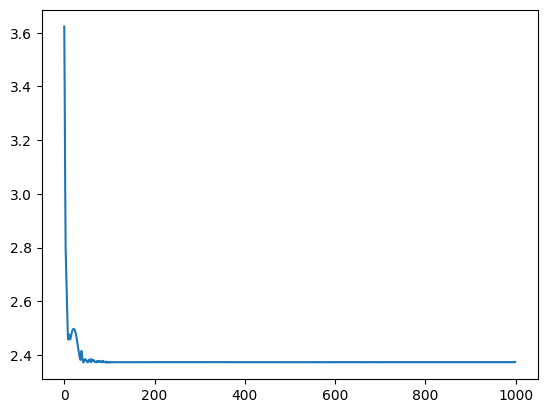

In [83]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [84]:
# get all combinations of 0, 1, 2 in torch
import itertools
list(itertools.permutations([0, 1, 2, 3]))
# convert the above to torch
O_list = []
cost_list = []
for O in torch.tensor(list(itertools.permutations([0, 1, 2, 3]))):
    O_list.append(O)
    cost_list.append(recourse_actions_torch(A_torch.squeeze(), X_torch.squeeze(), O.squeeze(), W_torch, betas_torch)[1].detach().numpy())

print(min(cost_list))
print(O_list[cost_list.index(min(cost_list))])

2.54234
tensor([3, 1, 2, 0])


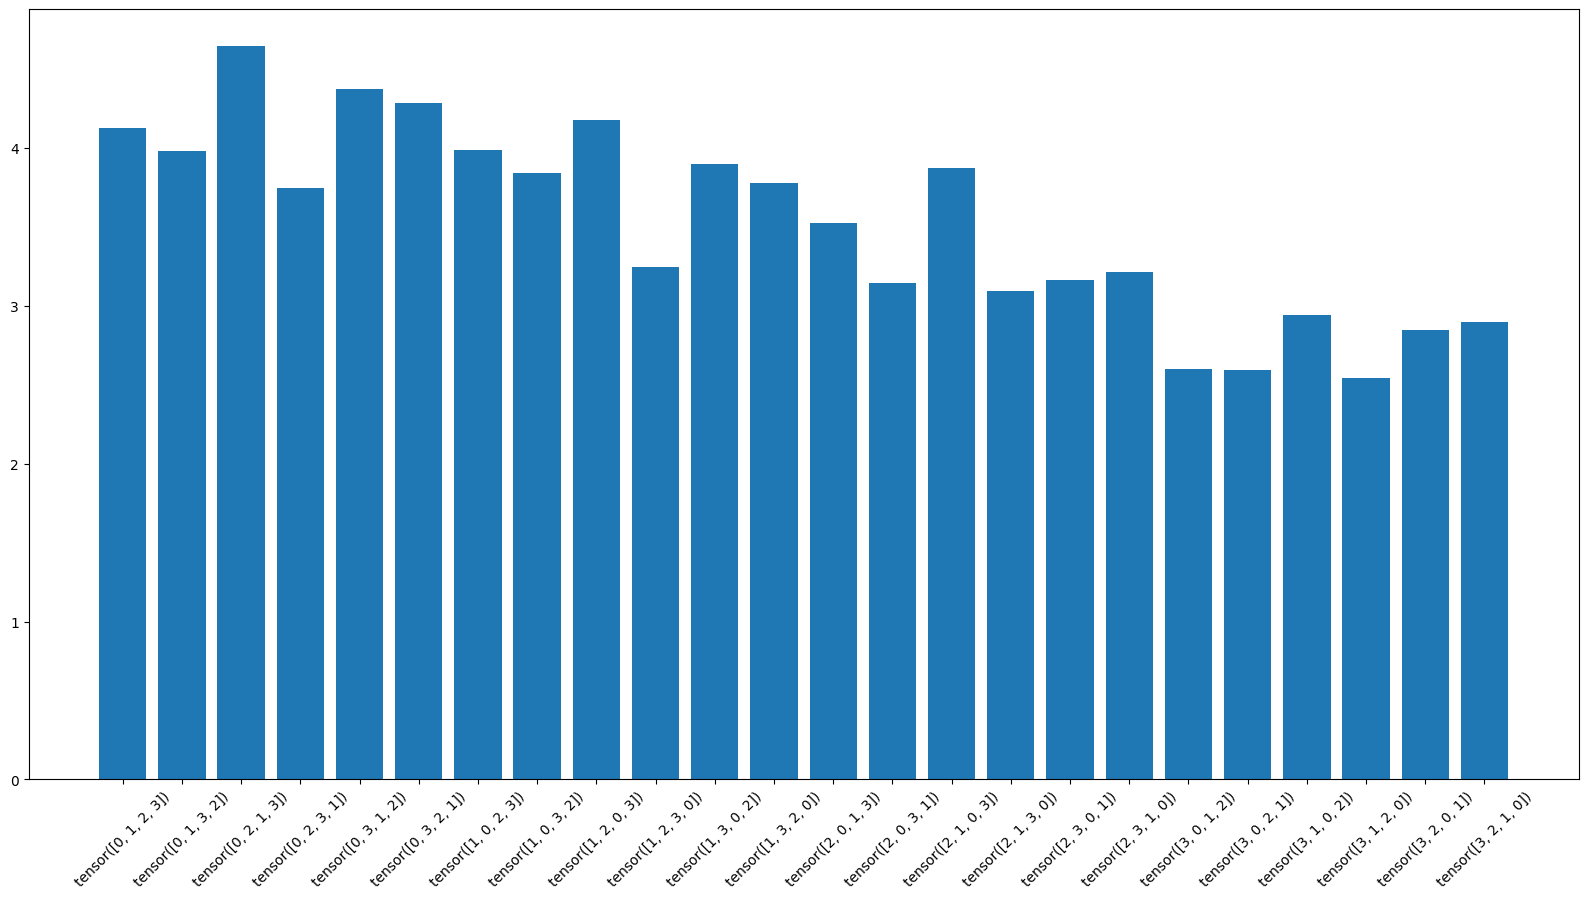

In [85]:
#plt.plot(cost_list)
plt.bar(range(len(cost_list)), cost_list)

# add x-axis labels from list of O's
plt.xticks(range(len(O_list)), O_list, rotation=45)
plt.gcf().set_size_inches(20, 10)

In [11]:
import optuna

def trial_objective(trial):
    tau = trial.suggest_uniform("tau", 0.01, 5)
    pow = trial.suggest_uniform("pow", 1, 3)

    A_torch = torch.tensor([[0.3, 0.1, -0.4]], dtype=torch.float32, requires_grad=True)
    X_torch = torch.tensor([[0.6, 0.8, 0.3]], dtype=torch.float32, requires_grad=True)
    O_torch = torch.tensor([[0, 1, 2]], dtype=torch.float32, requires_grad=True)
    #O_torch = torch.rand(1, 4, requires_grad=True)
    W_torch = torch.tensor(
        [
            [0.0, 0.0, 0.0],
            [0.2, 0.0, 0.0],
            [0.3, 0.4, 0.0],
        ], dtype=torch.float32
    )
    betas_torch = torch.tensor([1, 1, 1], dtype=torch.float32)
    sorter = SoftSort(tau=tau, hard=False, pow=pow)
    
    # generalized_recourse_actions_torch(A_torch, X_torch, O_torch, W_torch, betas_torch, sorter)
    
    #optimise generalized_recourse_actions_torch for O_torch
    optimizer = optim.AdamW([O_torch], lr=0.001)
    losses = []
    for i in range(1_000):
        optimizer.zero_grad()
        X_bars, costs = generalized_recourse_actions_torch(A_torch, X_torch, O_torch, W_torch, betas_torch, sorter)
        loss = torch.sum(costs)
        loss.backward()
        losses.append(loss.detach().numpy())
        optimizer.step()
    
    return loss.item()

# study = optuna.create_study(direction="minimize")
# study.optimize(trial_objective, n_trials=20)